# Analyzing and modifying a reduced basis after assembly

When solving parametrized eigenvalue problems using surrogates, the important question
arises, to what degree the surrogate actually reflects the behavior of the original
problem. In particular, one needs to know if the surrogate contains artifacts that
propagate to online measurements of observables. One possibility to evaluate the
surrogate quality is the direct comparison of observables and vectors obtained from the
reduced basis and truth solver. This, however, is a numerically demanding approach which
we will not cover here. So in this example we want to showcase some of the tools that
can be used to analyze and correct an assembled basis in the online stage and in a
computationally cheap way.

Before going into the specifics, we first setup an example for which we use the XXZ chain
where the snapshots are obtained using DMRG (see
Greedy basis assembly using DMRG).

In [1]:
using LinearAlgebra
using ITensors
using ReducedBasis
using Random: seed!
seed!(0)  # seed to make example consistent

function xxz_chain(sites::IndexSet; kwargs...)
    xy_term   = OpSum()
    zz_term   = OpSum()
    magn_term = OpSum()
    for i in 1:(length(sites) - 1)
        xy_term   += "Sx", i, "Sx", i + 1
        xy_term   += "Sy", i, "Sy", i + 1
        zz_term   += "Sz", i, "Sz", i + 1
        magn_term += "Sz", i
    end
    magn_term += "Sz", length(sites)  # Add last magnetization term
    coefficient_map = μ -> [1.0, μ[1], -μ[2]]
    AffineDecomposition([ApproxMPO(MPO(xy_term, sites), xy_term; kwargs...),
                         ApproxMPO(MPO(zz_term, sites), zz_term; kwargs...),
                         ApproxMPO(MPO(magn_term, sites), magn_term; kwargs...)],
                        coefficient_map)
end

L = 12
sites = siteinds("S=1/2", L)
H = xxz_chain(sites; cutoff=1e-9);
dm = DMRG(; n_states=1, tol_degeneracy=0.0, sweeps=default_sweeps(; cutoff_max=1e-9),
          observer=() -> DMRGObserver(; energy_tol=1e-9));
Δ = range(-1.0, 2.5; length=40)
hJ = range(0.0, 3.5; length=40)
grid_train = RegularGrid(Δ, hJ);

Up to this points we chose reasonable parameters for the basis assembly. However, we now
intend to generate a bad surrogate with purposefully bad settings. Namely, we limit our
basis size to `n_truth_max=6` truth solves and use a compression cutoff  of
`cutoff=1e-10` which is lower than the energy and singular value cutoff above:

In [2]:
greedy = Greedy(; estimator=Residual(), n_truth_max=8, init_from_rb=true)
edcomp = EigenDecomposition(; cutoff=0.0);

We therefore let unphysical modes eventually enter our basis. The first useful object
that we encounter is the `InfoCollector` that can be used to collect various
quantities that are computed in each greedy iteration. We chain the collector together
with the `print_callback` via the `∘` operator and use the resulting function
as the callback function during assembly:

In [3]:
collector = InfoCollector(:basis, :h_cache)
result = assemble(H, grid_train, greedy, dm, edcomp;
                  callback=collector ∘ print_callback);

n      max. err    ‖BᵀB-I‖     time      μ       
------------------------------------------------------------
1      NaN         6.66e-16     932ms    [-1.0, 0.0]
2      6.3         3.51e-16     1.41s    [2.5, 3.5]
3      3.36        6.27e-16     805ms    [2.5, 0.538]
4      1.52        3.08e-14     1.19s    [-0.282, 0.09]
5      1.87        1.63e-14     509ms    [2.5, 2.513]
6      0.934       5.88e-15     728ms    [0.795, 0.0]
7      0.726       5.86e-15     507ms    [0.077, 0.718]
8      0.868       6.57e-15     609ms    [2.5, 3.141]


Using this presumably inaccurate surrogate, we compute the magnetization

In [4]:
M = AffineDecomposition([H.terms[3]], μ -> [2 / L])
m, _ = compress(M, result.basis)
m_reduced = m([]);

on a finer online grid using the matching online solver

In [5]:
Δ_online = range(first(Δ), last(Δ); length=100)
hJ_online = range(first(hJ), last(hJ); length=100)
grid_online = RegularGrid(Δ_online, hJ_online)
fulldiag = FullDiagonalization(dm);

and additionally save all computed reduced basis vectors for later analysis:

In [6]:
using Statistics
rbvecs = Matrix{Matrix{ComplexF64}}(undef, size(grid_online))
magnetization = Matrix{Float64}(undef, size(grid_online))
for (idx, μ) in pairs(grid_online)
    _, φ_rb = solve(result.h_cache.h, result.basis.metric, μ, fulldiag)
    rbvecs[idx] = φ_rb
    magnetization[idx] = mean(u -> abs(dot(u, m_reduced, u)), eachcol(φ_rb))
end

We then end up with a magnetization heatmap that significantly deviates from the correct
phase diagram (compare e.g. with Greedy basis assembly using DMRG):

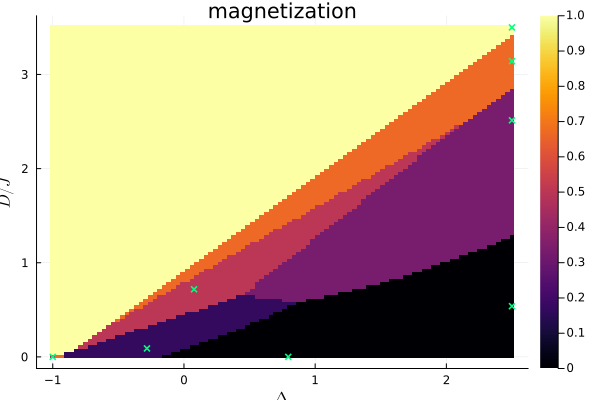

In [7]:
using Plots
xrange, yrange = grid_online.ranges[1], grid_online.ranges[2]
params = unique(result.basis.parameters)
xpoints, ypoints = [μ[1] for μ in params], [μ[2] for μ in params]
hm_kwargs = (; xlabel=raw"$\Delta$", ylabel=raw"$D/J$", colorbar=true, leg=false)
marker_kwargs = (; markershape=:xcross, mcolor=:springgreen, ms=3.0, msw=2.0);

hm = heatmap(xrange, yrange, magnetization';
             clims=(0.0, 1.0), title="magnetization", hm_kwargs...)
scatter!(hm, xpoints, ypoints; marker_kwargs...)

So what happened here (on purpose) is that the reduced basis does not contain enough
snapshots to fully resolve all features of the true phase diagram. To further dissect
the problems, let us look at some of the possible ways to analyze the basis, based on
the quantities we already have at our disposal.

## Online diagnostics

To visualize the degree to which the different snapshot vectors are "mixed" in the online
reduced basis vectors, we can compute the so-called *participation ratio*

$$
\mathrm{PR}(\varphi) = \frac{1}{d} \frac{1}{\sum_{k=1}^d |\varphi_k|^4}
$$

where we assume the RB vector $\varphi$ to normalized. For a maximally mixing RB vector
with elements $\varphi_k = 1/\sqrt{d}$ the participation ratio becomes maximal, whereas
a unit vector would produce the minimal participation ratio. The RB vectors from before
produce the following $\mathrm{PR}$:

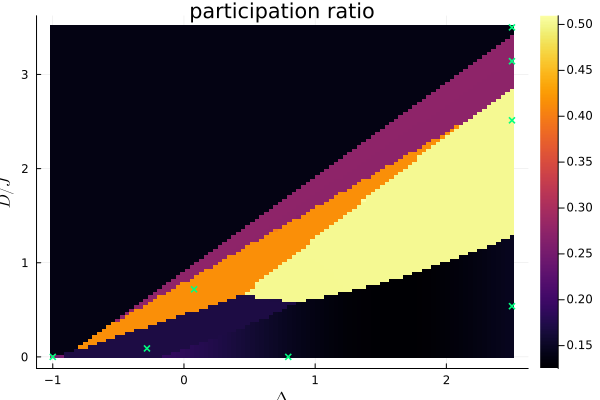

In [8]:
pr = map(rbvecs) do φ
    1 / sum(x -> abs(x)^4, φ)
end / size(rbvecs[1], 1)

hm = heatmap(xrange, yrange, pr'; title="participation ratio", hm_kwargs...)
scatter!(hm, xpoints, ypoints; marker_kwargs...)

Another way to look at the online vectors is to find the maximal coefficient of each
vector on the online grid and then assign it a color. The resulting heatmap displays —
depending on the compression method — Voronoi-like cells around the snapshot parameter
points. Using the collected info contained in the `collector`, we can even animate these
cells with respect to the greedy iterations:

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: linuxfb, minimal, offscreen, vnc, xcb.

Aborted (core dumped)
connect: Connection refused
GKS: can't connect to GKS socket application

GKS: Open failed in routine OPEN_WS
GKS: GKS not in proper state. GKS must be either in the state WSOP or WSAC in routine ACTIVATE_WS
qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: linuxfb, minimal, offscreen, vnc, xcb.

Aborted (core dumped)
connect: Connection refused
GKS: can't connect to GKS socket app

Plots.AnimatedGif("/tmp/jl_JeF03MTmxO.gif")
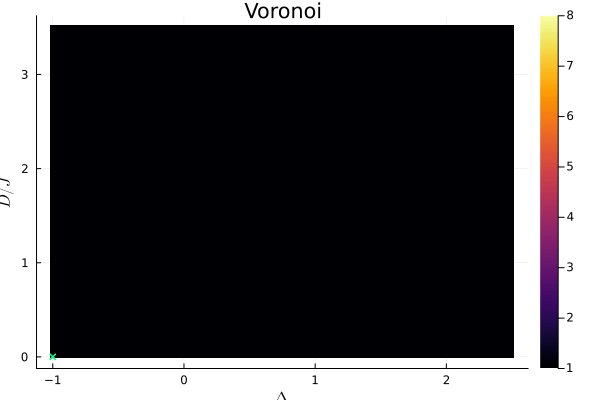

In [9]:
anim = @animate for n in 1:dimension(result.basis)
    data = collector.data
    vecs = map(grid_online) do μ
        solve(data[:h_cache][n].h, data[:basis][n].metric, μ, fulldiag)[2]
    end
    voronoi = map(φ -> findmax(abs.(@view φ[:, 1]))[2], vecs)
    hm = heatmap(xrange, yrange, voronoi';
                 title="Voronoi", clims=(1, 8), hm_kwargs...)
    p = unique(data[:basis][n].parameters)
    scatter!(hm, [μ[1] for μ in p], [μ[2] for μ in p]; marker_kwargs...)
end
gif(anim; fps=0.7)

We see that with each new snapshot we map out a new domain the parameter space. Hence to
further resolve the phase diagram, we will need to add more snapshots.

## Continuing an assembly

To continue assembling a basis, we can just call `assemble` and provide
the `result` tuple from the previous greedy assembly. Of course the remaining arguments
can be adjusted in the continued assembly, so let us now increase the maximal number of
truth solves:

In [10]:
greedy_cont = Greedy(; estimator=Residual(), n_truth_max=36)
result_cont = assemble(result, H, grid_train, greedy_cont, dm, edcomp);

n      max. err    ‖BᵀB-I‖     time      μ       
------------------------------------------------------------
9      0.723       6.57e-15     606ms    [0.795, 0.538]
10     0.814       1.59e-14     635ms    [2.5, 0.897]
11     0.708       2.57e-14     1.28s    [2.051, 2.423]
12     0.538       1.76e-13     615ms    [0.705, 0.897]
13     0.443       5e-14        814ms    [-0.103, 0.0]
14     0.274       5.15e-14     778ms    [-0.372, 0.269]
15     0.233       5e-14        1.69s    [-0.91, 0.0]
16     0.229       7.36e-14     828ms    [-0.462, 0.449]
17     0.113       2.75e-13     837ms    [-0.641, 0.09]
18     0.103       1.56e-13     2.28s    [-0.821, 0.09]
19     0.079       8.86e-13     1.34s    [1.782, 0.359]
20     0.0748      6.46e-13     1.08s    [-0.731, 0.09]
21     0.041       3.88e-12     1.09s    [1.692, 1.256]
22     0.0393      9.69e-12     1.27s    [-0.641, 0.0]
23     0.0269      9.04e-12     1.67s    [0.526, 1.436]
24     0.0933      4.8e-12      1.34s    [2.5, 3.41]


Apparently the assembly was stopped since an already solved snapshot was about to be
solved again — which cannot happen in a correctly assembled greedy basis, indicating that
the online evaluations of observables will contain artifacts. So let us check that by
recomputing the magnetization using the continued basis:

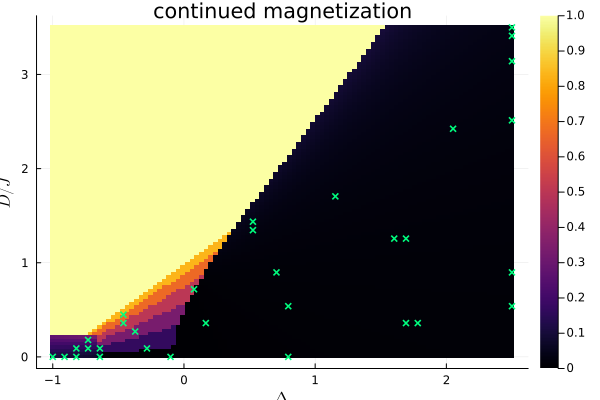

In [11]:
m_cont, m_cont_raw = compress(M, result_cont.basis)
m_reduced_cont = m_cont([])

magn_cont = map(grid_online) do μ
    _, φ_rb = solve(result_cont.h_cache.h, result_cont.basis.metric, μ, fulldiag)
    mean(u -> abs(dot(u, m_reduced_cont, u)), eachcol(φ_rb))
end
hm = heatmap(xrange, yrange, magn_cont';
             clims=(0.0, 1.0), title="continued magnetization", hm_kwargs...)
params = unique(result_cont.basis.parameters)
scatter!(hm, [μ[1] for μ in params], [μ[2] for μ in params]; marker_kwargs...)

Indeed the magnetization heatmap seems to be broken (again compare with
Greedy basis assembly using DMRG); the phase diagram contains a large artifact
related to the $M=0$ plateau. In these cases, we need to fix the reduced basis by
removing snapshots from it.

## Truncation of snapshots

Fortunately, the greedy assembly is irreversible, meaning we can `truncate` our
`RBasis` to a desired number of truth solves. Let us remove the last few snapshots
to correct the error incurred by repeated MPS approximations:

In [12]:
basis_trunc = truncate(result_cont.basis, 30);

Since we performed multiple compressions using the previous `result_cont.basis`, we also
need to truncate the `HamiltonianCache` according to the truncated basis:

In [13]:
h_cache_trunc = truncate(result_cont.h_cache, basis_trunc);

A slightly more subtle thing occurs with the compressed `AffineDecomposition`s.
Here we need to provide the second return argument `m_cont_raw` of the compressed magnetization from
above:

In [14]:
m_trunc = truncate(m_cont_raw, basis_trunc)
m_reduced_trunc = m_trunc([]);

Finally, let us recompute the magnetization but this time with the truncated
quantities and check the heatmap plot:

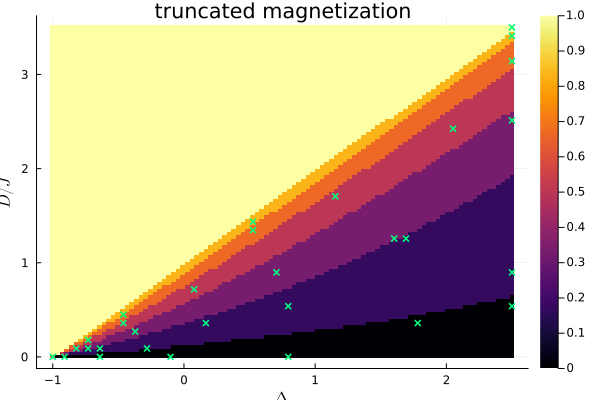

In [15]:
magn_trunc = map(grid_online) do μ
    _, φ_rb = solve(h_cache_trunc.h, basis_trunc.metric, μ, fulldiag)
    mean(u -> abs(dot(u, m_reduced_trunc, u)), eachcol(φ_rb))
end
hm = heatmap(xrange, yrange, magn_trunc';
             clims=(0.0, 1.0), title="truncated magnetization", hm_kwargs...)
params = unique(basis_trunc.parameters)
scatter!(hm, [μ[1] for μ in params], [μ[2] for μ in params]; marker_kwargs...)

By truncating the basis and all compressed quantities, we have recovered the phase
diagram. This process did not involve any computationally expensive operations and
can therefore be always performed as a consistency check on a generated basis.